In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np


In [2]:
blinds1 = pd.read_csv("../datasets/blinds_meetingroom_1.csv")
blinds2 = pd.read_csv("../datasets//blinds_meetingroom_2.csv")
blinds3 = pd.read_csv("../datasets//blinds_meetingroom_3_offset2seconds.csv")
blinds4 = pd.read_csv("../datasets//blinds_meetingroom_4.csv")

hallway1 = pd.read_csv("../datasets//hallway_1.csv")
hallway2 = pd.read_csv("../datasets/hallway_2.csv")
hallway3 = pd.read_csv("../datasets/hallway_3.csv")
hallway4 = pd.read_csv("../datasets/hallway_4.csv")

windows1 = pd.read_csv("../datasets/windows_meetingroom_1.csv")
windows2 = pd.read_csv("../datasets/windows_meetingroom_2.csv")
windows3 = pd.read_csv("../datasets/windows_meetingroom_3.csv")
windows4 = pd.read_csv("../datasets/windows_meetingroom_4.csv")

In [3]:
# assign labels + group IDs
dfs   = [blinds1, blinds2, blinds3,
         hallway1, hallway2, hallway3,
         windows1, windows2, windows3]

labels   = []
groups   = []
group_id = 0

for df in dfs:
    # determine room type from filename in practice
    if group_id < 3:
        room = "BLINDS"
    elif group_id < 6:
        room = "HALLWAYS"
    else:
        room = "WINDOWS"
    labels += [room] * len(df)
    groups += [group_id] * len(df)
    group_id += 1

X_train = pd.concat(dfs, axis=0, ignore_index=True)
y_train = np.array(labels)
groups  = np.array(groups)

# feature selection & label encoding
numeric_cols = X_train.select_dtypes(include="number").columns
X_train = X_train[numeric_cols].astype(float)

le = LabelEncoder()
y_train = le.fit_transform(y_train)   # 0=BLINDS,1=HALLWAYS,2=WINDOWS

# pipeline and parameter grid
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",    SVC(decision_function_shape="ovo", probability=True))
])

param_grid = {
    "svm__C":     [0.1, 1, 10],
    "svm__gamma": ["scale", 0.01, 0.001],
   
}

# 3‑fold GroupKFold CV (each fold holds out one trial)
gkf = GroupKFold(n_splits=3)

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=gkf.split(X_train, y_train, groups),
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# grid search
search.fit(X_train, y_train)

# results
print("Best params:", search.best_params_)
print(f"Best CV accuracy: {search.best_score_:.4f}\n")

cv_results = pd.DataFrame(search.cv_results_)
print(cv_results[[
    "param_svm__C", "param_svm__gamma",
    "mean_test_score", "std_test_score"
]])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'svm__C': 10, 'svm__gamma': 0.001}
Best CV accuracy: 0.9073

   param_svm__C param_svm__gamma  mean_test_score  std_test_score
0           0.1            scale         0.847245        0.083087
1           0.1             0.01         0.890673        0.101203
2           0.1            0.001         0.704941        0.112776
3           1.0            scale         0.893550        0.121648
4           1.0             0.01         0.906977        0.109206
5           1.0            0.001         0.904390        0.094613
6          10.0            scale         0.895320        0.126466
7          10.0             0.01         0.899577        0.135348
8          10.0            0.001         0.907329        0.117858


Test accuracy on trial 4:  0.9350253807106599

Classification report:
              precision    recall  f1-score   support

      BLINDS       0.87      0.97      0.92       360
    HALLWAYS       1.00      1.00      1.00       302
     WINDOWS       0.96      0.84      0.89       323

    accuracy                           0.94       985
   macro avg       0.94      0.94      0.94       985
weighted avg       0.94      0.94      0.93       985



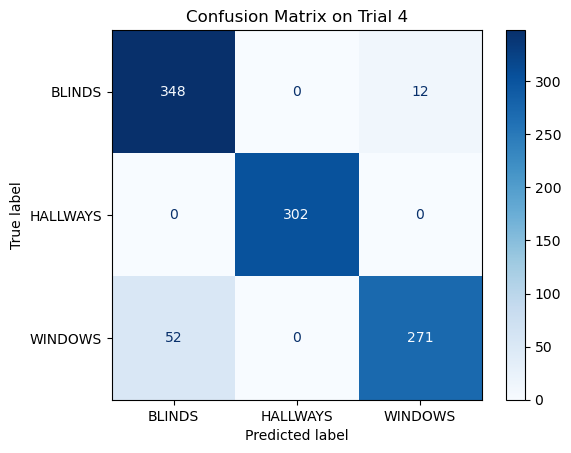

In [4]:
dfs_test = [blinds4, hallway4, windows4]
labels_test = (["BLINDS"]  * len(blinds4)
             + ["HALLWAYS"] * len(hallway4)
             + ["WINDOWS"] * len(windows4))

X_test = pd.concat(dfs_test, axis=0, ignore_index=True)
y_test = np.array(labels_test)


X_test = X_test[numeric_cols].astype(float)

y_test_enc = le.transform(y_test)    # BLINDS→0, HALLWAYS→1, WINDOWS→2

best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

print("Test accuracy on trial 4: ", accuracy_score(y_test_enc, y_pred))
print("\nClassification report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred, display_labels=le.classes_,
    cmap=plt.cm.Blues, normalize=None
)
plt.title("Confusion Matrix on Trial 4")
plt.show()